<a href="https://colab.research.google.com/github/Giuseppe86-lab/Face-Detection-no-NN-/blob/main/Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduzione

Questo progetto mi ha permesso di confrontarmi con il problema della gestione delle immagini e del caricamento di dataset esterni nel mio notebook. Per prepararmi per questo progetto ho dovuto leggere un buon numero di articoli trovati su diversi blog tecnici, riporto i link principali della mia sitografia:

1. [HOG Feature Visualization](https://www.geeksforgeeks.org/hog-feature-visualization-in-python-using-skimage/?utm_source=chatgpt.com)
2. [Non-Maximum Suppression](https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/)
3. [Image Pyramids](https://pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/)

Per quanto riguarda i dataset nella prima versione ho usato:

1. **Olivetti Faces** eseguendo delle rotazioni dei volti e delle simmetrie per ampliare i volti di training.
2. **Caltech 101** per avere delle immagini no faces.

Ma quando ho testato il mio modello su foto esterne con più volti, i riconoscimenti non erano soddisfacenti quindi ho usato il dataset **LFW** per avere volti in contenti più vari e **CIFAR-100** e **Imagenette** per i non volti, creando così un dataset formato da 2500 volti e 10000 non volti.

# 0. Importazione Moduli

In [ ]:
import cv2
import numpy as np
import os
import glob
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from imutils.object_detection import non_max_suppression
from imutils import resize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from skimage.color import rgb2gray
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import get_file
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

In [ ]:
#Definisco le costanti
RANDOM_SEED = 42

# 1 Download e Preparazione Dataset

Credits: LFW Dataset, CIFAR-100 Dataset, Imagenette

In [ ]:
# Caricamento dataset volti da LFW
lfw_faces = fetch_lfw_people(color=True, resize=1.0)
faces = lfw_faces.images
faces = (faces * 255).astype(np.uint8)
faces = [cv2.resize(img, (64, 64)) for img in random.sample(list(faces), min(len(faces), 2500))]

In [ ]:
print(lfw_faces.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenCV li

In [ ]:
# Caricamento dataset non-volti da CIFAR-100
(cifar_train, _), (cifar_test, _) = cifar100.load_data()
non_faces = np.concatenate((cifar_train, cifar_test), axis=0)
non_faces = [cv2.resize(img, (64, 64)) for img in non_faces]

In [ ]:
# Caricamento dataset Imagenette da tensorflow_datasets
dataset = tfds.load('imagenette/full-size', split='train', as_supervised=True)
imagenette_images = []

for img, _ in tfds.as_numpy(dataset.take(2000)):
    img_resized = cv2.resize(tf.keras.preprocessing.image.img_to_array(img), (64, 64))
    imagenette_images.append(img_resized)

In [ ]:
non_faces = list(non_faces) + imagenette_images
non_faces = random.sample(non_faces, min(len(non_faces), 10000))

X = np.array(faces + non_faces)
y = np.array([1] * len(faces) + [0] * len(non_faces))

print(f'Numero di immagini con volti: {len(faces)}')
print(f'Numeto di immagini senza volti: {len(non_faces)}')

Numero di immagini con volti: 2500
Numeto di immagini senza volti: 10000


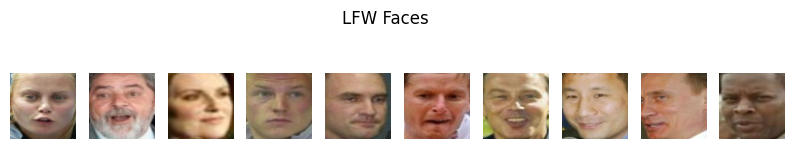

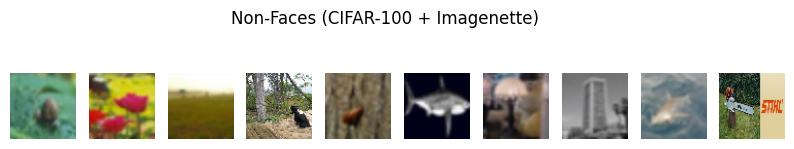

In [ ]:
# Stampa di 10 immagini casuali per ciascun dataset
def plot_samples(images, title):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i].astype(np.uint8))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_samples(faces[:10], "LFW Faces")
plot_samples(non_faces[:10], "Non-Faces (CIFAR-100 + Imagenette)")

# 2 Estrazione Feature Hog e Preprocessing

Creo la classe Preprocessor(BaseEstimator, TransformerMixin) per poterla inserire nella pipeline del modello.

Questa classe gestisce il resize della finestra passata, la standardizzazione dei valori dei pixel e l'estrazione delle HOG features sia per immagini a colori che in bianco e nero.

In [ ]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, img_size=(64, 64), pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.img_size = img_size
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.scaler = MinMaxScaler()
        self.fitted = False

    def fit(self, X, y=None):
        features = self._extract_features(X)
        self.scaler.fit(features)
        self.fitted = True
        return self

    def transform(self, X):
        features = self._extract_features(X)
        if self.fitted:
            features = self.scaler.transform(features)
        return features

    def _extract_features(self, X):
        features = []
        for img in X:
            img_resized = cv2.resize(img, self.img_size)
            if len(img_resized.shape) == 3:  # Converti solo se RGB
                img_resized = rgb2gray(img_resized)
            hog_feat = hog(img_resized,
                           pixels_per_cell=self.pixels_per_cell,
                           cells_per_block=self.cells_per_block,
                           feature_vector=True)
            features.append(hog_feat)
        return np.array(features)

# 3 Creazione Pipeline SVM con GridSearch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_SEED)
print(f'X_train: {len(X_train)} - X_test: {len(X_test)}')

X_train: 10000 - X_test: 2500


Creazione della pipeline e fine tuning della Linear Support Vector Machine attraverso GridSearchCV, nella pipeline c'è anche una PCA per estrarre le 200 features principali al fine di diminuire l'overfitting e migliorare le prestazioni del modello anche in termini di tempo computazionale.

In [ ]:
# Parametri per GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'loss': ['hinge', 'squared_hinge']}

grid_search = GridSearchCV(LinearSVC(max_iter=10000, class_weight='balanced'), param_grid, cv=5, verbose=1, n_jobs=-1)

face_detection_pipeline = Pipeline([
    ('preprocessing', Preprocessor()),
    ('pca', PCA(n_components=200)),
    ('svm', grid_search)
])

face_detection_pipeline.fit(X_train, y_train)

# Accesso ai migliori parametri dalla GridSearchCV
best_params = face_detection_pipeline.named_steps['svm'].best_estimator_.get_params()
best_score = face_detection_pipeline.named_steps['svm'].best_score_
print("Migliori parametri:", best_params)
print("Miglior accuracy:", best_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Migliori parametri: {'C': 0.01, 'class_weight': 'balanced', 'dual': 'auto', 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Miglior accuracy: 0.9936999999999999


# 4 Valutazione del modello

In [ ]:
y_train_pred = face_detection_pipeline.predict(X_train)
y_test_pred = face_detection_pipeline.predict(X_test)
print("Train Classification Report:\n", classification_report(y_train, y_train_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8000
           1       0.99      0.99      0.99      2000

    accuracy                           1.00     10000
   macro avg       0.99      1.00      0.99     10000
weighted avg       1.00      1.00      1.00     10000

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2000
           1       0.97      0.98      0.98       500

    accuracy                           0.99      2500
   macro avg       0.98      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



Le prestazioni sia sul set di Train che di Test sono ottime.

# 5 Rilevamento Volti con Sliding Window e NMS

La classe detect_faces sarà quella che gestirà sia lo Sliding Window che la Non-Max-Suppression. Lo sliding serve per scansionare l'immagine divisa per finestre, su ogni finestra verrà applicata la pipeline del modello per cercare i volti. La NMS unisce le celle con almeno il 30% di sovrapposizione che hanno trovato un volto.

Avevo anche provato ad implementare una multiscale detection ma i tempi computazionali aumentavano in modo significativo, senza un sostanziale aumento delle prestazioni.

Essendo stato richiesta nella consegna un modello che usasse poche risorse computazionali, ho pensato di non implementare la multiscale detection nella versione finale di questo progetto.

In [ ]:
def detect_faces(image, model, win_size=(64,64), step_size=8):
  detections = []

  #Verifica se l'immagine è più piccola della finestra, in tal caso verrà ridimensionata
  if image.shape[0]<win_size[1] or image.shape[1]<win_size[0]:
    image = cv2.resize(image, (win_size[0], win_size[1]))

  for y in range(0, image.shape[0]-win_size[1], step_size):
    for x in range(0, image.shape[1]-win_size[0], step_size):
      window = image[y:y+win_size[1], x:x+win_size[0]]
      window = cv2.resize(window, (64,64))
      pred = model.predict([window])
      if pred == 1:
        detections.append((x,y,x+win_size[0], y+win_size[1]))
  detections = np.array(detections)
  if len(detections) > 0:
    detections = non_max_suppression(detections, probs=None, overlapThresh=0.3)

  return detections

## 5.A Test su Immagini Esterne

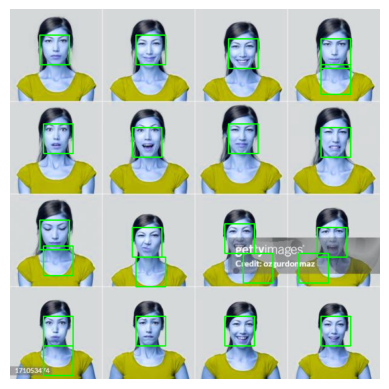

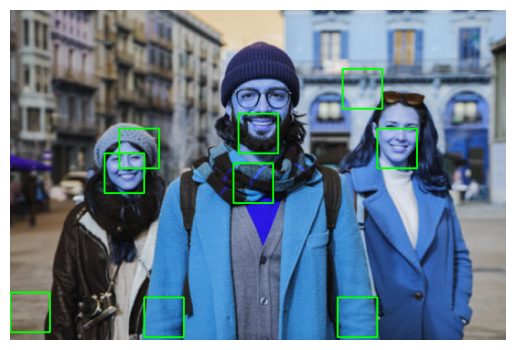

In [ ]:
test_image = cv2.imread("volti.jpg")
test_image = resize(test_image, width=800)
detections = detect_faces(test_image, face_detection_pipeline)

#Visualizzazione risultati
for (x1,y1,x2,y2) in detections:
  cv2.rectangle(test_image, (x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(test_image)
plt.axis('off')
plt.show()

#print(detections)

test_image2 = cv2.imread("test_face1.jpg")
test_image2 = resize(test_image2, width=800)
detections = detect_faces(test_image2, face_detection_pipeline)

#Visualizzazione risultati
for (x1,y1,x2,y2) in detections:
  cv2.rectangle(test_image2, (x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(test_image2)
plt.axis('off')
plt.show()

Dai risultati del test vediamo che il modello risponde sufficientemente bene ma fatica con volti che hanno dimensioni diverse da quelle di training.